## This notebook is for assessing ORF6-CTR as a model system 

## Introduction 

This jupyter notebook contains sample code to analyse metadynamic simulations of the 61-residue ORF6 from SARS-CoV-2 in the `AMBER03ws` force field at 310 K. These simulations were performed using `GROMACS 2021.2` (1) patched with the `PLUMED` library `version 2.7.1` (2).

Amino acid sequence: `SKSLTENKYSQLDEEQPMEID` from the trajectory of `MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTENKYSQLDEEQPMEID` 

## Preprocessing of the trajectories using GROMACS 

Partial trajectories for each replica were first concatenated using the `GROMACS` `gmx trjcat` command to obtain full trajectories per replica. 

Time-ordered trajectories from each replica were concatenated together to a single, large trajectory using the `GROMACS gmx trjcat` command. The `PLUMED driver` command was then used to recalcuate the weights on this large trajectory.

The weights of frames in which the protein interacts with its periodic image have already been set to zero. These frames were identified using the `GROMACS gmx mindist` command. The cut-off for self-interaction was set to 1.2 nm for `AMBER03ws`. 

From the `AMBER03ws`trajectories, less than 1.2% of the ensemble (by metadynamics weight) were removed. 

We discard a total of 35% of the trajectory from the `AMBER03ws` trajectory for equilibration (see `Blocking analysis and equilibration of weights`)
        
Parts of the analysis code have been adapted from ref (3), GitHub: https://github.com/gthh2/amyloid-beta_small_mol/blob/master/Metadynamic_metainference/Analysis/Metadynamic_metainference_analysis.ipynb
    
<b> References <b> 

(1) Abraham MJ, Murtola T, Schulz R, Páll S, Smith JC, Hess B, Lindah E. 2015. GROMACS: High performance molecular simulations through multi-level parallelism from laptops to supercomputers. SoftwareX. 1–2:19–25. 

(2) Bonomi M, Bussi G, Camilloni C, Tribello GA, Banáš P, Barducci A, et al. 2019. Promoting transparency and reproducibility in enhanced molecular simulations. Nat Methods. 16:670–3.
    
(3) Heller GT, Aprile FA, Michaels TCT, Limbocker R, Perni M, Ruggeri FS, et al. 2020. Small-molecule sequestration of amyloid-β as a drug discovery strategy for Alzheimer’s disease. Sci Adv. 6.

## To set up 
Select CTR from the full-length trajectory using gromacs processing. 

Then just load this CTR trajectory into the notebook 

gmx trjconv -f ../traj_all-skip-4-noW-whole.trr -s ../../../orf6_protein/all-atom/a03ws/sims/7-npt-metad/r0/7-npt-metad.tpr -n ctr.ndx -o traj_all-skip-4-noW-whole-ctr.trr

gmx trjconv -f ../traj_all-skip-4-noW-whole.trr -s ../../../orf6_protein/all-atom/a99sb/sims/7-npt-metad/r0/7-npt-metad.tpr -n ctr.ndx -o traj_all-skip-4-noW-whole-ctr.trr

gmx trjconv -f ../traj_all-skip-6-noW-whole.trr -s ../../../orf6_protein/all-atom/c36m/sims/7-npt-metad/r0/7-npt-metad.tpr -n ctr.ndx -o traj_all-skip-6-noW-whole-ctr.trr


## Setup the notebook 

In [2]:
#Import useful tools
import mdtraj as md
import numpy as np
import matplotlib.colors as clr
import pandas as pd
from glob import glob
from itertools import *
import math
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import sys
sys.path.append('..')
import os 
from math import pi
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import norm
from scipy.spatial import distance
import lmfit
from lmfit import Model
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
import warnings

In [3]:
# turn off future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Define function to return the weighted average and standard deviation
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [5]:
#Define presets for plotting
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=8)

# force fields colours (a= simulation, b=reweighted for each force field) 
a_a03ws = (1,0.6471,0) #FFA500(255,165,0) 
b_a03ws = (0.6,0.39,0) #996300(153, 99, 0)
a_a03ws_run2 = (0,0.8,0.8) #00cdcd(0,205,205)
b_a03ws_run2 = (0,0.34,0.34) #005757(0,87,87)
a_a99sb = (0.86,0.08,0.24) #dc143c(220,20,60)
a_c36m = (0.39,0.58,0.93) #6495ED(100,149,237)
b_c36m = (0.16,0.23,0.37) #283B5E(40,59,94)

a_a03ws_fl = (0.48,0.51,1) #7a81ff 122, 129, 255 (full-length orf6)

# C-alpha contacts map 
cmap_con_a03ws_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',a_a03ws], N=256, gamma=1.0)
cmap_con_a03ws_run2_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',a_a03ws_run2], N=256, gamma=1.0)
cmap_con_a99sb_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',a_a99sb], N=256, gamma=1.0)
cmap_con_c36m_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',a_c36m], N=256, gamma=1.0)

# C-alpha contacts map reweighted 
cmap_con_a03ws_rw_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',b_a03ws], N=256, gamma=1.0)
cmap_con_a03ws_run2_rw_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',b_a03ws_run2], N=256, gamma=1.0)
cmap_con_c36m_rw_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',b_c36m], N=256, gamma=1.0)

# define colours for cis and trans 
orf6_ctr_cis = (1, 0, 1) # ff00ff
orf6_ctr_trans = (0.22,0.49,0.16) #rgb(55,126,34) green

# Contacts map 
cmap_con_cis_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',orf6_ctr_cis], N=256, gamma=1.0)
cmap_con_trans_calpha  = clr.LinearSegmentedColormap.from_list('name', ['w','grey',orf6_ctr_trans], N=256, gamma=1.0)

In [6]:
# Load corrected metadynamics weights for full-length 

## Load corrected metadynamics weights 
w_a03ws_orf6 = np.loadtxt('Metadynamic_ORF6_full_length_simulations_Zenodo/weights_corr.dat')

# normalise the weights 
w_a03ws_orf6 /= w_a03ws_orf6.sum() 

# Calculate the kish for each system (how many structures describe the ensemble) 

kish_a03ws_orf6 = ((w_a03ws_orf6.sum())*(w_a03ws_orf6.sum()))/((w_a03ws_orf6*w_a03ws_orf6).sum())
print('a03ws kish:', kish_a03ws_orf6)

a03ws kish: 24080.46397961272


In [7]:
# Define number of replicas 
n_reps = 128

In [8]:
#Given that the simulations is arranged as 128 time-ordered replicas
# we split up the weights into 128 separate arrays

## a03ws orf6 
w_a03ws_orf6_split = np.split(w_a03ws_orf6, n_reps)
# length of each replica 
length_w_a03ws_orf6=(len(w_a03ws_orf6)/n_reps) 
# Removing first 35% 
keep_w_a03ws_orf6 = np.floor((length_w_a03ws_orf6)*0.65) # Removing first 35% 
keep_w_a03ws_orf6
for i in range(0, n_reps):
    #Set first values in ORF6-CTR ensemble to zero 
    w_a03ws_orf6_split[i][0:(len(w_a03ws_orf6)/n_reps-keep_w_a03ws_orf6).astype(int)] = 0 
#Concatenate the separate arrays again
w_a03ws_orf6_eq = np.hstack(w_a03ws_orf6_split) 
#Renormalise metadynamics weights 
w_a03ws_orf6_eq /= w_a03ws_orf6_eq.sum() 
# print to check weights are normalised 
print('check a03ws_orf6 weights:', sum(w_a03ws_orf6_eq))

check a03ws_orf6 weights: 1.000000000000011


## Load trajectories 

Below is just the CTR (last 21 residues) of the full length metadynamic simulation 
- Need to update pdb

In [11]:
## Load trajectories
t_a03ws_orf6 = md.load('Metadynamic_ORF6_full_length_simulations_Zenodo/traj_all-skip-4-noW-whole-ctr.trr', top='model_ctr/frame0.pdb')

## Load in the CTR data for comparison 

In [15]:
## Load trajectories
t_a03ws_run1 = md.load('Metadynamic_simulations_Zenodo/a03ws_run1_traj.trr', top='Metadynamic_simulations_Zenodo/a03ws.pdb')
t_a03ws_run2 = md.load('Metadynamic_simulations_Zenodo/a03ws_run2_traj.trr', top='Metadynamic_simulations_Zenodo/a03ws.pdb')

In [16]:
## Load corrected metadynamics weights for CTR 
w_a03ws_run1 = np.loadtxt('Metadynamic_simulations_Zenodo/a03ws_run1_weights_corr.dat')
w_a03ws_run2 = np.loadtxt('Metadynamic_simulations_Zenodo/a03ws_run2_weights_corr.dat')

# normalise the weights 
w_a03ws_run1 /= w_a03ws_run1.sum() 
w_a03ws_run2 /= w_a03ws_run2.sum() 

# Calculate the kish for each system (how many structures describe the ensemble) 

kish_a03ws_run1 = ((w_a03ws_run1.sum())*(w_a03ws_run1.sum()))/((w_a03ws_run1*w_a03ws_run1).sum())
print('a03ws run1 kish:', kish_a03ws_run1)

kish_a03ws_run2 = ((w_a03ws_run2.sum())*(w_a03ws_run2.sum()))/((w_a03ws_run2*w_a03ws_run2).sum())
print('a03ws run2 kish:', kish_a03ws_run2)

a03ws run1 kish: 33816.763095643284
a03ws run2 kish: 35364.16560027782


In [17]:
#Given that the simulations is arranged as 128 time-ordered replicas
# we split up the weights into 128 separate arrays

## a03ws run1 
w_a03ws_run1_split = np.split(w_a03ws_run1, n_reps)
# length of each replica 
length_w_a03ws_run1=(len(w_a03ws_run1)/n_reps) 
# Removing first 35% 
keep_w_a03ws_run1 = np.floor((length_w_a03ws_run1)*0.65) # Removing first 35% 
keep_w_a03ws_run1
for i in range(0, n_reps):
    #Set first values in ORF6-CTR ensemble to zero 
    w_a03ws_run1_split[i][0:(len(w_a03ws_run1)/n_reps-keep_w_a03ws_run1).astype(int)] = 0 
#Concatenate the separate arrays again
w_a03ws_run1_eq = np.hstack(w_a03ws_run1_split) 
#Renormalise metadynamics weights 
w_a03ws_run1_eq /= w_a03ws_run1_eq.sum() 
# print to check weights are normalised 
print('check a03ws_run1 weights:', sum(w_a03ws_run1_eq))

## a03ws run2 
w_a03ws_run2_split = np.split(w_a03ws_run2, n_reps)
length_w_a03ws_run2=(len(w_a03ws_run2)/n_reps) 
keep_w_a03ws_run2 = np.floor((length_w_a03ws_run2)*0.65) # Removing first 35% 
keep_w_a03ws_run2
for i in range(0, n_reps):
    w_a03ws_run2_split[i][0:(len(w_a03ws_run2)/n_reps-keep_w_a03ws_run2).astype(int)] = 0 
w_a03ws_run2_eq = np.hstack(w_a03ws_run2_split) 
w_a03ws_run2_eq /= w_a03ws_run2_eq.sum() 
print('check a03ws_run2 weights:', sum(w_a03ws_run2_eq))

check a03ws_run1 weights: 0.9999999999999956
check a03ws_run2 weights: 0.9999999999999934


In [18]:
# Calculate the kish after equilibration 

# kish_a03ws run 1
kish_a03ws_run1_eq = ((w_a03ws_run1_eq.sum())*(w_a03ws_run1_eq.sum()))/((w_a03ws_run1_eq*w_a03ws_run1_eq).sum())
print('a03ws kish after eq:', kish_a03ws_run1_eq)

# kish a03ws run2
kish_a03ws_run2_eq = ((w_a03ws_run2_eq.sum())*(w_a03ws_run2_eq.sum()))/((w_a03ws_run2_eq*w_a03ws_run2_eq).sum())
print('a03ws_run2 kish after eq:', kish_a03ws_run2_eq)

a03ws kish after eq: 22022.236821220296
a03ws_run2 kish after eq: 22795.379936748304


## Split for error analysis 

In [19]:
## a03ws run 1 

start_a03ws_orf6 = (len(w_a03ws_orf6_eq)/n_reps-keep_w_a03ws_orf6).astype(int)
end_a03ws_orf6 = int((len(w_a03ws_orf6_eq)/128))
mid_a03ws_orf6 = (start_a03ws_orf6 + (end_a03ws_orf6-start_a03ws_orf6)/2).astype(int)

#Reshape weights array to account for individual replicas
w_a03ws_orf6_eq_reps = np.reshape(w_a03ws_orf6_eq.copy(), (n_reps, int(len(w_a03ws_orf6_eq)/n_reps), 1))

#Make separate weight arrays for the first and second halves of the trajectory
w_a03ws_orf6_eq_0 = w_a03ws_orf6_eq_reps.copy()[:, start_a03ws_orf6:mid_a03ws_orf6]
w_a03ws_orf6_eq_1 = w_a03ws_orf6_eq_reps.copy()[:, mid_a03ws_orf6:end_a03ws_orf6]

#Use this to determine effective weight of first and second halves of the trajectory
sum_w_a03ws_orf6_eq_0 = w_a03ws_orf6_eq_0.sum()
sum_w_a03ws_orf6_eq_1 = w_a03ws_orf6_eq_1.sum()

#Normalise weights of first and second halves of the trajectory R
w_a03ws_orf6_eq_0 /= w_a03ws_orf6_eq_0.sum()      
w_a03ws_orf6_eq_1 /= w_a03ws_orf6_eq_1.sum() 

In [20]:
## a03ws run 1 

start_a03ws_run1 = (len(w_a03ws_run1_eq)/n_reps-keep_w_a03ws_run1).astype(int)
end_a03ws_run1 = int((len(w_a03ws_run1_eq)/128))
mid_a03ws_run1 = (start_a03ws_run1 + (end_a03ws_run1-start_a03ws_run1)/2).astype(int)

#Reshape weights array to account for individual replicas
w_a03ws_run1_eq_reps = np.reshape(w_a03ws_run1_eq.copy(), (n_reps, int(len(w_a03ws_run1_eq)/n_reps), 1))

#Make separate weight arrays for the first and second halves of the trajectory
w_a03ws_run1_eq_0 = w_a03ws_run1_eq_reps.copy()[:, start_a03ws_run1:mid_a03ws_run1]
w_a03ws_run1_eq_1 = w_a03ws_run1_eq_reps.copy()[:, mid_a03ws_run1:end_a03ws_run1]

#Use this to determine effective weight of first and second halves of the trajectory
sum_w_a03ws_run1_eq_0 = w_a03ws_run1_eq_0.sum()
sum_w_a03ws_run1_eq_1 = w_a03ws_run1_eq_1.sum()

#Normalise weights of first and second halves of the trajectory R
w_a03ws_run1_eq_0 /= w_a03ws_run1_eq_0.sum()      
w_a03ws_run1_eq_1 /= w_a03ws_run1_eq_1.sum() 

In [21]:
## a03ws run 2

start_a03ws_run2 = (len(w_a03ws_run2_eq)/n_reps-keep_w_a03ws_run2).astype(int)
end_a03ws_run2 = int((len(w_a03ws_run2_eq)/128))
mid_a03ws_run2 = (start_a03ws_run2 + (end_a03ws_run2-start_a03ws_run2)/2).astype(int)

#Reshape weights array to account for individual replicas
w_a03ws_run2_eq_reps = np.reshape(w_a03ws_run2_eq.copy(), (n_reps, int(len(w_a03ws_run2_eq)/n_reps), 1))

#Make separate weight arrays for the first and second halves of the trajectory
w_a03ws_run2_eq_0 = w_a03ws_run2_eq_reps.copy()[:, start_a03ws_run2:mid_a03ws_run2]
w_a03ws_run2_eq_1 = w_a03ws_run2_eq_reps.copy()[:, mid_a03ws_run2:end_a03ws_run2]

#Use this to determine effective weight of first and second halves of the trajectory
sum_w_a03ws_run2_eq_0 = w_a03ws_run2_eq_0.sum()
sum_w_a03ws_run2_eq_1 = w_a03ws_run2_eq_1.sum()

#Normalise weights of first and second halves of the trajectory 
w_a03ws_run2_eq_0 /= w_a03ws_run2_eq_0.sum()      
w_a03ws_run2_eq_1 /= w_a03ws_run2_eq_1.sum() 

## CamShift analysis 

Removing K42, S43, L44, and T45 because they shift a bit - assumption later residues will not 

plumed driver --mf_trr traj_all-skip-4-noW-whole-ctr.trr --plumed camshift_plumed.dat

In [22]:
#Define camshift errors (from reference (7))
camshift_errs = {'ca': 1.3, 'cb': 1.36, 'ha': 0.28, 'hn': 0.56}

In [24]:
# Load in CAMSHIFT output for each system 

cs_a03ws_orf6 = pd.read_csv('model_ctr/CS_COLVAR', delim_whitespace=True, dtype=float, header=0)

In [25]:
# Define a dictionary for each residue 

cs_residues = {'ca': [46,47,48,49,50,51,52,53,54,55,56,57,58,59,60],
               'cb': [46,47,48,49,50,52,53,54,55,58,59],
               'ha': [46,47,48,49,50,51,52,53,54,55,56,57,58,59,60],
               'hn': [46,47,48,49,50,51,52,53,54,55,56,58,59,60]
}

In [26]:
# Define experimental chemical shift data dictionary (same for each force field) 

data_dict = {
             'ca': np.asarray(cs_a03ws_orf6.loc[:, 'cs.expca-0-6':'cs.expca-0-20']), 
             'cb': np.asarray(cs_a03ws_orf6.loc[:, 'cs.expcb-0-6':'cs.expcb-0-19']),
             'ha': np.asarray(cs_a03ws_orf6.loc[:, 'cs.expha-0-6':'cs.expha-0-20']),
             'hn': np.asarray(cs_a03ws_orf6.loc[:, 'cs.exphn-0-6':'cs.exphn-0-20']),
}

In [27]:
# Define predicted chemical shift data 

cs_a03ws_orf6_dict = {
             'ca': np.asarray(cs_a03ws_orf6.loc[:, 'cs.ca-0-6':'cs.ca-0-20']), 
             'cb': np.asarray(cs_a03ws_orf6.loc[:, 'cs.cb-0-6':'cs.cb-0-19']),
             'hn': np.asarray(cs_a03ws_orf6.loc[:, 'cs.hn-0-6':'cs.hn-0-20']), 
             'ha': np.asarray(cs_a03ws_orf6.loc[:, 'cs.ha-0-6':'cs.ha-0-20']),
}

In [28]:
#Define empty dictionaries for a03ws orf6 
cs_a03ws_orf6_reps = {} 
cs_a03ws_orf6_means = {}
cs_a03ws_orf6_means_0 = {}
cs_a03ws_orf6_means_1 = {}
cs_a03ws_orf6_std = {}
for k in cs_residues.keys():
    #Reshape chemical shift arrays to account for individual replicas
    cs_a03ws_orf6_reps[k] = np.reshape(cs_a03ws_orf6_dict[k], (n_reps, int(len(w_a03ws_orf6_eq)/n_reps), -1))
    #Make dictionary containing means calculated over whole trajectory
    cs_a03ws_orf6_means[k] = (w_a03ws_orf6_eq_reps*cs_a03ws_orf6_reps[k]).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing means calculated over first half of trajectory
    cs_a03ws_orf6_means_0[k] = (cs_a03ws_orf6_reps[k][:, start_a03ws_orf6:mid_a03ws_orf6]*w_a03ws_orf6_eq_0).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing means calculated over second half of trajectory
    cs_a03ws_orf6_means_1[k] = (cs_a03ws_orf6_reps[k][:, mid_a03ws_orf6:end_a03ws_orf6]*w_a03ws_orf6_eq_1).sum(tuple(j for j in (0, 1)))
    #Make dictionary containing standard deviations calculated between first and second halves
    cs_a03ws_orf6_std[k] = [weighted_avg_and_std([cs_a03ws_orf6_means_0[k][i], cs_a03ws_orf6_means_1[k][i]], [sum_w_a03ws_orf6_eq_0, sum_w_a03ws_orf6_eq_1])[1] for i in range(0, cs_a03ws_orf6_means_0[k].shape[0])]

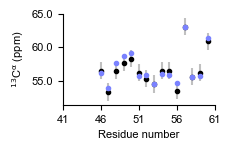

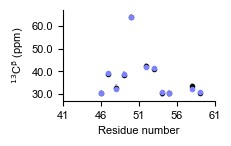

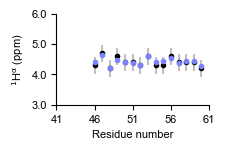

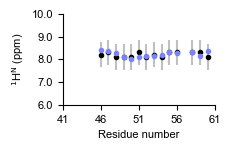

In [29]:
## a03ws run 1 

# Define atom labels 
atom_labels = {
    'ha': r'$^1$H$\mathrm{^\alpha}$',
    'hn': r'$^1$H$\mathrm{^N}$',
    'ca': r'$^{13}$C$\mathrm{^\alpha}$',
    'cb': r'$^{13}$C$\mathrm{^\beta}$'
}

for k in cs_residues.keys():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.errorbar(cs_residues[k], data_dict[k].mean(axis=0), yerr=np.full(len(cs_residues[k]), camshift_errs[k]), fmt='o', markersize='3', color='black', ecolor='silver')
    ax.errorbar(cs_residues[k], cs_a03ws_orf6_means[k], yerr=cs_a03ws_orf6_std[k], fmt='o', markersize='3', ecolor=a_a03ws, elinewidth=1, color=a_a03ws_fl)
    ax.set_xlabel("Residue number")
    ax.set_ylabel("{} (ppm)".format(atom_labels[k]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xticks(np.arange(41, 62, step=5));
    
    if k == 'hn': 
        ax.set_ylim(6, 10)
        
    if k == 'ha': 
        ax.set_ylim(3, 6)
    
    plt.gcf().set_size_inches(50/25.4,30/25.4)

In [30]:
# a03ws run 1 
for k in cs_residues.keys():
    rmsd_a03ws_orf6_0 = np.sqrt(((cs_a03ws_orf6_means_0[k] - data_dict[k]) ** 2).mean())
    rmsd_a03ws_orf6_1 = np.sqrt(((cs_a03ws_orf6_means_1[k] - data_dict[k]) ** 2).mean())
    err_a03ws_orf6_rmsd = weighted_avg_and_std([(rmsd_a03ws_orf6_0), (rmsd_a03ws_orf6_1)], [sum_w_a03ws_orf6_eq_0, sum_w_a03ws_orf6_eq_1])
    print('a03ws_orf6 rmsd:', k, err_a03ws_orf6_rmsd)

a03ws_orf6 rmsd: ca (0.6654138314822085, 0.011053712340208036)
a03ws_orf6 rmsd: cb (0.4905720790095668, 0.0036494016455605304)
a03ws_orf6 rmsd: ha (0.07357827279086847, 0.00045292091742959865)
a03ws_orf6 rmsd: hn (0.13243258914505934, 0.004818406808471389)


In [31]:
#Remove ACE group from NAc-ORF6-CTR
t_a03ws_run1_no_ACE = t_a03ws_run1.atom_slice(t_a03ws_run1.top.select('not resid 0'))
t_a03ws_run2_no_ACE = t_a03ws_run2.atom_slice(t_a03ws_run2.top.select('not resid 0'))

## Radius of gyration 

In [32]:
#Calculate radius of gyration on all atoms 
masses_a03ws_orf6= np.array([a.element.mass for a in t_a03ws_orf6.top.atoms])
rg_a03ws_orf6= md.compute_rg(t_a03ws_orf6, masses=masses_a03ws_orf6)

Divide the Rg into two halves for convergence analysis 

In [33]:
# a03ws full length 
rg_a03ws_orf6_reps = np.reshape(rg_a03ws_orf6, (n_reps, int(len(w_a03ws_orf6_eq)/n_reps), 1))
rg_a03ws_orf6_0 = rg_a03ws_orf6_reps.copy()[:, start_a03ws_orf6:mid_a03ws_orf6]
rg_a03ws_orf6_1 = rg_a03ws_orf6_reps.copy()[:, mid_a03ws_orf6:end_a03ws_orf6]
err_rg_a03ws_orf6 = weighted_avg_and_std([(rg_a03ws_orf6_0*w_a03ws_orf6_eq_0).sum(), (rg_a03ws_orf6_1*w_a03ws_orf6_eq_1).sum()], [sum_w_a03ws_orf6_eq_0, sum_w_a03ws_orf6_eq_1])[1]

In [34]:
#Calculate radius of gyration on all atoms 
masses_a03ws_run1_no_ACE= np.array([a.element.mass for a in t_a03ws_run1_no_ACE.top.atoms])
rg_a03ws_run1_no_ACE = md.compute_rg(t_a03ws_run1_no_ACE, masses=masses_a03ws_run1_no_ACE)

#Calculate radius of gyration on all atoms 
masses_a03ws_run2_no_ACE= np.array([a.element.mass for a in t_a03ws_run2_no_ACE.top.atoms])
rg_a03ws_run2_no_ACE = md.compute_rg(t_a03ws_run2_no_ACE, masses=masses_a03ws_run2_no_ACE)

In [35]:
# a03ws run 1 
rg_a03ws_run1_reps_no_ACE = np.reshape(rg_a03ws_run1_no_ACE, (n_reps, int(len(w_a03ws_run1_eq)/n_reps), 1))
rg_a03ws_run1_0_no_ACE = rg_a03ws_run1_reps_no_ACE.copy()[:, start_a03ws_run1:mid_a03ws_run1]
rg_a03ws_run1_1_no_ACE = rg_a03ws_run1_reps_no_ACE.copy()[:, mid_a03ws_run1:end_a03ws_run1]
err_rg_a03ws_run1_no_ACE = weighted_avg_and_std([(rg_a03ws_run1_0_no_ACE*w_a03ws_run1_eq_0).sum(), (rg_a03ws_run1_1_no_ACE*w_a03ws_run1_eq_1).sum()], [sum_w_a03ws_run1_eq_0, sum_w_a03ws_run1_eq_1])[1]

In [36]:
# a03ws run 2
rg_a03ws_run2_reps_no_ACE = np.reshape(rg_a03ws_run2_no_ACE, (n_reps, int(len(w_a03ws_run2_eq)/n_reps), 1))
rg_a03ws_run2_0_no_ACE = rg_a03ws_run2_reps_no_ACE.copy()[:, start_a03ws_run2:mid_a03ws_run2]
rg_a03ws_run2_1_no_ACE = rg_a03ws_run2_reps_no_ACE.copy()[:, mid_a03ws_run2:end_a03ws_run2]
err_rg_a03ws_run2_no_ACE = weighted_avg_and_std([(rg_a03ws_run2_0_no_ACE*w_a03ws_run2_eq_0).sum(), (rg_a03ws_run2_1_no_ACE*w_a03ws_run2_eq_1).sum()], [sum_w_a03ws_run2_eq_0, sum_w_a03ws_run2_eq_1])[1]

In [37]:
# simulation Rg
print('The average radius of gyration for a03ws ORF6 CTR is ', round((rg_a03ws_orf6 * w_a03ws_orf6_eq).sum(), 5), '+/-', round(err_rg_a03ws_orf6, 5))

print('The average radius of gyration for a03ws run1 ORF6 CTR without ACE is ', round((rg_a03ws_run1_no_ACE * w_a03ws_run1_eq).sum(), 5), '+/-', round(err_rg_a03ws_run1_no_ACE, 5)) 
print('The average radius of gyration for a03ws run2 ORF6 CTR without ACE is ', round((rg_a03ws_run2_no_ACE * w_a03ws_run2_eq).sum(), 5), '+/-', round(err_rg_a03ws_run2_no_ACE, 5)) 

The average radius of gyration for a03ws ORF6 CTR is  1.1687 +/- 0.00987
The average radius of gyration for a03ws run1 ORF6 CTR without ACE is  1.18344 +/- 0.00201
The average radius of gyration for a03ws run2 ORF6 CTR without ACE is  1.17958 +/- 0.00192


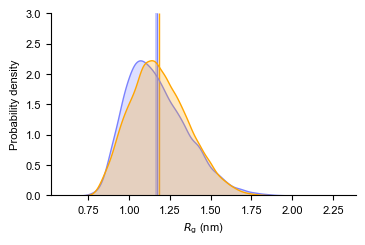

In [38]:
# All 3 simulation ensembles (only a03ws run 1) 

fig, ax = plt.subplots(figsize=(2, 2))

sns.kdeplot(x=rg_a03ws_orf6, fill='True', color=a_a03ws_fl, weights=w_a03ws_orf6_eq, zorder=1, linewidth=1)
sns.kdeplot(x=rg_a03ws_run1_no_ACE, fill='True', color=a_a03ws, weights=w_a03ws_run1_eq, zorder=1, linewidth=1)

ax.vlines((rg_a03ws_orf6 * w_a03ws_orf6_eq).sum(), 0, 3, color=a_a03ws_fl, linewidth=1,zorder=0)
ax.axvspan((rg_a03ws_orf6*w_a03ws_orf6_eq).sum()+err_rg_a03ws_orf6,(rg_a03ws_orf6*w_a03ws_orf6_eq).sum()-err_rg_a03ws_orf6, 0, 3, facecolor=a_a03ws_fl, alpha=0.4,zorder=0) 

ax.vlines((rg_a03ws_run1_no_ACE * w_a03ws_run1_eq).sum(), 0, 3, color=a_a03ws, linewidth=1,zorder=0)
ax.axvspan((rg_a03ws_run1_no_ACE*w_a03ws_run1_eq).sum()+err_rg_a03ws_run1_no_ACE,(rg_a03ws_run1_no_ACE*w_a03ws_run1_eq).sum()-err_rg_a03ws_run1_no_ACE, 0, 3, facecolor=a_a03ws, alpha=0.4,zorder=0) 

ax.set_xlabel(r"$\mathbf{\mathit{R}}_{\mathrm{g}}$ (nm)")
ax.set_ylabel("Probability density")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,3)

plt.gcf().set_size_inches(100/25.4, 60/25.4)

In [39]:
## DSSP analysis 

In [40]:
orf6_resid = np.arange(41,62)

In [41]:
# dssp for ctr from full-length

dssp_a03ws_orf6 = md.compute_dssp(t_a03ws_orf6, simplified=True)

# Set values to 1 for coil
coil_a03ws_orf6 = np.zeros_like(dssp_a03ws_orf6, dtype=int)
# Set the elements to 1 where dssp_a03ws_run1_rw is 'C'
coil_a03ws_orf6[dssp_a03ws_orf6 == 'C'] = 1

# Set values to 1 for strand
strand_a03ws_orf6 = np.zeros_like(dssp_a03ws_orf6, dtype=int)
# Set the elements to 1 where dssp_a03ws_run1_rw is 'E'
strand_a03ws_orf6[dssp_a03ws_orf6 == 'E'] = 1

# Set values to 1 for helix
helix_a03ws_orf6 = np.zeros_like(dssp_a03ws_orf6, dtype=int)
# Set the elements to 1 where dssp_a03ws_run1_rw is 'H'
helix_a03ws_orf6[dssp_a03ws_orf6 == 'H'] = 1

avg_coil_a03ws_orf6 = np.zeros((21), dtype=object)

for i in range(0, 21):
    avg_coil_a03ws_orf6[i] = (coil_a03ws_orf6[:, i] * w_a03ws_orf6_eq).sum()
    
avg_strand_a03ws_orf6 = np.zeros((21), dtype=object)

for i in range(0, 21):
    avg_strand_a03ws_orf6[i] = (strand_a03ws_orf6[:, i] * w_a03ws_orf6_eq).sum()
    
avg_helix_a03ws_orf6 = np.zeros((21), dtype=object)

for i in range(0, 21):
    avg_helix_a03ws_orf6[i] = (helix_a03ws_orf6[:, i] * w_a03ws_orf6_eq).sum()
    
# Split traj for coil, helix and strand 
coil_a03ws_orf6_reps = np.reshape(coil_a03ws_orf6, (n_reps, int(len(w_a03ws_orf6)/n_reps), 21))
coil_a03ws_orf6_0 = coil_a03ws_orf6_reps.copy()[:, start_a03ws_orf6:mid_a03ws_orf6]
coil_a03ws_orf6_1 = coil_a03ws_orf6_reps.copy()[:, mid_a03ws_orf6:end_a03ws_orf6]

# Split traj for helix, helix and strand 
helix_a03ws_orf6_reps = np.reshape(helix_a03ws_orf6, (n_reps, int(len(w_a03ws_orf6)/n_reps), 21))
helix_a03ws_orf6_0 = helix_a03ws_orf6_reps.copy()[:, start_a03ws_orf6:mid_a03ws_orf6]
helix_a03ws_orf6_1 = helix_a03ws_orf6_reps.copy()[:, mid_a03ws_orf6:end_a03ws_orf6]

# Split traj for strand, strand and strand 
strand_a03ws_orf6_reps = np.reshape(strand_a03ws_orf6, (n_reps, int(len(w_a03ws_orf6)/n_reps), 21))
strand_a03ws_orf6_0 = strand_a03ws_orf6_reps.copy()[:, start_a03ws_orf6:mid_a03ws_orf6]
strand_a03ws_orf6_1 = strand_a03ws_orf6_reps.copy()[:, mid_a03ws_orf6:end_a03ws_orf6]

err_coil_a03ws_orf6 = np.zeros(21)

for i in range(0,21):
    coil_a03ws_orf6_tuple = weighted_avg_and_std([
        (coil_a03ws_orf6_0[:, :, i][:, :, np.newaxis] * w_a03ws_orf6_eq_0).sum(),
        (coil_a03ws_orf6_1[:, :, i][:, :, np.newaxis] * w_a03ws_orf6_eq_1).sum()
    ], [sum_w_a03ws_orf6_eq_0, sum_w_a03ws_orf6_eq_1])
    
    # Extract the relevant value from the result tuple
    coil_a03ws_orf6_result = coil_a03ws_orf6_tuple[1]  
    
    err_coil_a03ws_orf6[i] = coil_a03ws_orf6_result
    
err_helix_a03ws_orf6 = np.zeros(21)

for i in range(0,21):
    helix_a03ws_orf6_tuple = weighted_avg_and_std([
        (helix_a03ws_orf6_0[:, :, i][:, :, np.newaxis] * w_a03ws_orf6_eq_0).sum(),
        (helix_a03ws_orf6_1[:, :, i][:, :, np.newaxis] * w_a03ws_orf6_eq_1).sum()
    ], [sum_w_a03ws_orf6_eq_0, sum_w_a03ws_orf6_eq_1])
    
    # Extract the relevant value from the result tuple
    helix_a03ws_orf6_result = helix_a03ws_orf6_tuple[1]  
    
    err_helix_a03ws_orf6[i] = helix_a03ws_orf6_result
    
err_strand_a03ws_orf6 = np.zeros(21)

for i in range(0,21):
    strand_a03ws_orf6_tuple = weighted_avg_and_std([
        (strand_a03ws_orf6_0[:, :, i][:, :, np.newaxis] * w_a03ws_orf6_eq_0).sum(),
        (strand_a03ws_orf6_1[:, :, i][:, :, np.newaxis] * w_a03ws_orf6_eq_1).sum()
    ], [sum_w_a03ws_orf6_eq_0, sum_w_a03ws_orf6_eq_1])
    
    # Extract the relevant value from the result tuple
    strand_a03ws_orf6_result = strand_a03ws_orf6_tuple[1]  
    
    err_strand_a03ws_orf6[i] = strand_a03ws_orf6_result

In [42]:
# dssp for ctr from full-length (excluding the ACE here)

dssp_a03ws_run1 = md.compute_dssp(t_a03ws_run1_no_ACE, simplified=True)

# Set values to 1 for coil
coil_a03ws_run1 = np.zeros_like(dssp_a03ws_run1, dtype=int)
# Set the elements to 1 where dssp_a03ws_run1_rw is 'C'
coil_a03ws_run1[dssp_a03ws_run1 == 'C'] = 1

# Set values to 1 for strand
strand_a03ws_run1 = np.zeros_like(dssp_a03ws_run1, dtype=int)
# Set the elements to 1 where dssp_a03ws_run1_rw is 'E'
strand_a03ws_run1[dssp_a03ws_run1 == 'E'] = 1

# Set values to 1 for helix
helix_a03ws_run1 = np.zeros_like(dssp_a03ws_run1, dtype=int)
# Set the elements to 1 where dssp_a03ws_run1_rw is 'H'
helix_a03ws_run1[dssp_a03ws_run1 == 'H'] = 1

avg_coil_a03ws_run1 = np.zeros((21), dtype=object)

for i in range(0, 21):
    avg_coil_a03ws_run1[i] = (coil_a03ws_run1[:, i] * w_a03ws_run1_eq).sum()
    
avg_strand_a03ws_run1 = np.zeros((21), dtype=object)

for i in range(0, 21):
    avg_strand_a03ws_run1[i] = (strand_a03ws_run1[:, i] * w_a03ws_run1_eq).sum()
    
avg_helix_a03ws_run1 = np.zeros((21), dtype=object)

for i in range(0, 21):
    avg_helix_a03ws_run1[i] = (helix_a03ws_run1[:, i] * w_a03ws_run1_eq).sum()
    
# Split traj for coil, helix and strand 
coil_a03ws_run1_reps = np.reshape(coil_a03ws_run1, (n_reps, int(len(w_a03ws_run1)/n_reps), 21))
coil_a03ws_run1_0 = coil_a03ws_run1_reps.copy()[:, start_a03ws_run1:mid_a03ws_run1]
coil_a03ws_run1_1 = coil_a03ws_run1_reps.copy()[:, mid_a03ws_run1:end_a03ws_run1]

# Split traj for helix, helix and strand 
helix_a03ws_run1_reps = np.reshape(helix_a03ws_run1, (n_reps, int(len(w_a03ws_run1)/n_reps), 21))
helix_a03ws_run1_0 = helix_a03ws_run1_reps.copy()[:, start_a03ws_run1:mid_a03ws_run1]
helix_a03ws_run1_1 = helix_a03ws_run1_reps.copy()[:, mid_a03ws_run1:end_a03ws_run1]

# Split traj for strand, strand and strand 
strand_a03ws_run1_reps = np.reshape(strand_a03ws_run1, (n_reps, int(len(w_a03ws_run1)/n_reps), 21))
strand_a03ws_run1_0 = strand_a03ws_run1_reps.copy()[:, start_a03ws_run1:mid_a03ws_run1]
strand_a03ws_run1_1 = strand_a03ws_run1_reps.copy()[:, mid_a03ws_run1:end_a03ws_run1]

err_coil_a03ws_run1 = np.zeros(21)

for i in range(0,21):
    coil_a03ws_run1_tuple = weighted_avg_and_std([
        (coil_a03ws_run1_0[:, :, i][:, :, np.newaxis] * w_a03ws_run1_eq_0).sum(),
        (coil_a03ws_run1_1[:, :, i][:, :, np.newaxis] * w_a03ws_run1_eq_1).sum()
    ], [sum_w_a03ws_run1_eq_0, sum_w_a03ws_run1_eq_1])
    
    # Extract the relevant value from the result tuple
    coil_a03ws_run1_result = coil_a03ws_run1_tuple[1]  
    
    err_coil_a03ws_run1[i] = coil_a03ws_run1_result
    
err_helix_a03ws_run1 = np.zeros(21)

for i in range(0,21):
    helix_a03ws_run1_tuple = weighted_avg_and_std([
        (helix_a03ws_run1_0[:, :, i][:, :, np.newaxis] * w_a03ws_run1_eq_0).sum(),
        (helix_a03ws_run1_1[:, :, i][:, :, np.newaxis] * w_a03ws_run1_eq_1).sum()
    ], [sum_w_a03ws_run1_eq_0, sum_w_a03ws_run1_eq_1])
    
    # Extract the relevant value from the result tuple
    helix_a03ws_run1_result = helix_a03ws_run1_tuple[1]  
    
    err_helix_a03ws_run1[i] = helix_a03ws_run1_result
    
err_strand_a03ws_run1 = np.zeros(21)

for i in range(0,21):
    strand_a03ws_run1_tuple = weighted_avg_and_std([
        (strand_a03ws_run1_0[:, :, i][:, :, np.newaxis] * w_a03ws_run1_eq_0).sum(),
        (strand_a03ws_run1_1[:, :, i][:, :, np.newaxis] * w_a03ws_run1_eq_1).sum()
    ], [sum_w_a03ws_run1_eq_0, sum_w_a03ws_run1_eq_1])
    
    # Extract the relevant value from the result tuple
    strand_a03ws_run1_result = strand_a03ws_run1_tuple[1]  
    
    err_strand_a03ws_run1[i] = strand_a03ws_run1_result

In [43]:
# Define the width of the bars
width = 0.35

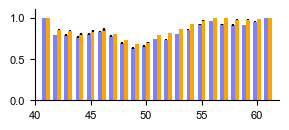

In [44]:
# Set the figure size in millimeters
fig, ax = plt.subplots(figsize=(80/25.4,30/25.4))  # 1 inch = 25.4 mm

# Plot orf6 from full length 
ax.bar(orf6_resid - width/2, avg_coil_a03ws_orf6, width, color=a_a03ws_fl,linewidth=1,yerr=err_coil_a03ws_orf6)

# Plot ctr without ACE
ax.bar(orf6_resid + width/2, avg_coil_a03ws_run1, width, color=a_a03ws,linewidth=1,yerr=err_coil_a03ws_run1)

# Set the x-axis labels
ax.set_xticks([40,45,50,55,60])
ax.set_yticks([0.0,0.5,1])

ax.set_ylim(0,1.1)
ax.set_xlim(40,62)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

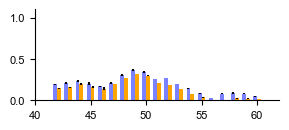

In [48]:
# Set the figure size in millimeters
fig, ax = plt.subplots(figsize=(80/25.4,30/25.4))  # 1 inch = 25.4 mm

# Plot orf6 from full length 
ax.bar(orf6_resid - width/2, avg_helix_a03ws_orf6, width, color=a_a03ws_fl,linewidth=1,yerr=err_helix_a03ws_orf6)

# Plot ctr without ACE
ax.bar(orf6_resid + width/2, avg_helix_a03ws_run1, width, color=a_a03ws,linewidth=1,yerr=err_helix_a03ws_run1)

# Set the x-axis labels
ax.set_xticks([40,45,50,55,60])
ax.set_yticks([0.0,0.5,1])

ax.set_ylim(0,1.1)
ax.set_xlim(40,62)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

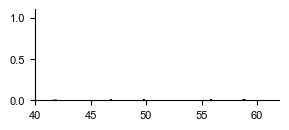

In [49]:
# Define the width of the bars
width = 0.35

# Set the figure size in millimeters
fig, ax = plt.subplots(figsize=(80/25.4,30/25.4))  # 1 inch = 25.4 mm

# Plot orf6 from full length 
ax.bar(orf6_resid - width/2, avg_strand_a03ws_orf6, width, color=a_a03ws_fl,linewidth=1,yerr=err_strand_a03ws_orf6)

# Plot ctr without ACE
ax.bar(orf6_resid + width/2, avg_strand_a03ws_run1, width, color=a_a03ws,linewidth=1,yerr=err_strand_a03ws_run1)

# Set the x-axis labels
ax.set_xticks([40,45,50,55,60])
ax.set_yticks([0.0,0.5,1])

ax.set_ylim(0,1.1)
ax.set_xlim(40,62)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [47]:
## The End !!